## Decision Trees

#### *08 November 2020*

#### *DATA 1010*


Today, we will learn how to use decision trees to solve classification & regression problems.

In [1]:
using Plots, Interact
import DecisionTree, StatsBase
include("gini-game.jl")

┌ Info: Precompiling Interact [c601a237-2ae4-5e1e-952c-7a85b0c7eef1]
└ @ Base loading.jl:1278


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-14502161899089510912\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-11911910139519680994\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-14502161899089510912\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

gini_game (generic function with 1 method)

---

## Problem 1

A horticulture company has genetically engineered three flower species, each with a different color: red, green and blue. Coincidentally, the color of the flower can be pre-determined by the length and width of its petals, using the following algorithm: 

```
if petal has width less than 4, 
    if petal has length less than 1
        the color is blue
    else if petal has width less than 2
        the flower is green
    else 
        if petal has length greater than 3
            the flower is green
        else
            the flower is blue
else 
    the flower is red
```

(a) Draw the 2D region corresponding to the color of the flower species, given the petal length and width (you can just do this on paper). Assume that the length and width of the petals range between $0$ cm and $5$ cm.

(b) Draw the decision tree corresponding to the algorithm above.

(c) Is it possible to create a more concise algorithm (i.e. with fewer if/else statements) to classify a flower?

*Solution*. 

---

Although training decision trees *optimally* in general is computationally infeasible, we can train them *greedily* by looking at each step for the feature and threshold which do the best job of separating classes. We measure how well classes are separated using **Gini impurity**. Given a collection of labeled items, its Gini impurity is defined to be the probability that two items drawn independently and uniformly at random from the collection have distinct labels. In other words, if the class proportions are $p_1, p_2, \ldots, p_n$, the Gini impurity is $1 - p_1^2 - \ldots - p_n^2$. 

The loss function we use to select the best threshold is an average of the Gini impurities of the two collections we get when we perform the proposed split. To discourage the algorithm from giving highly imbalanced splits, we use as weights the proportions of observations on the two sides of the threshold.

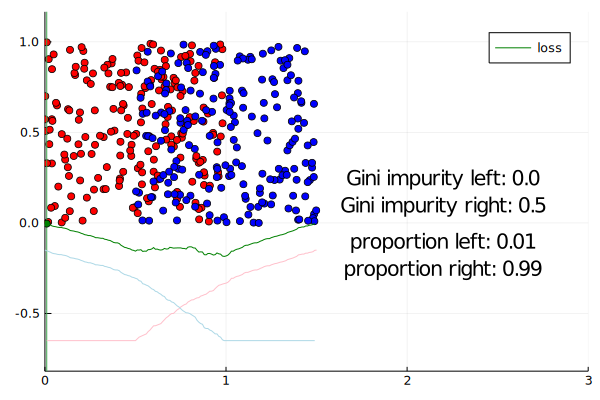

In [3]:
# @manipulate for x in -0:0.01:1.5
x = 0.01
threshold_visualization(x)
# end

## Problem 2

Run the `gini_game` function below and see if you can intuit which split (the first row or the second row) has the lower Gini impurity loss $p_1G_1 + p_2G_2$. After practicing for a bit, do 10 runs under the supervision of a partner and see how many you can get right. There is some luck involved, since sometimes the losses will be very close, and you'll pretty much have to guess randomly. 

Note that the locations of the points have no meaning in this game.

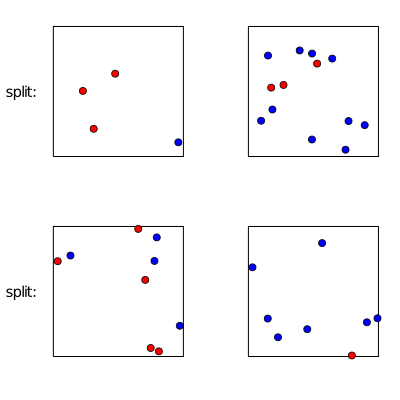

In [4]:
gini_game(20)

In [5]:
print(score_report)

loss for row 1: 0.35972850678733037
loss for row 2: 0.3643790849673203


---

## Problem 3

Consider the decision boundaries shown in the plot below:

<img src="decision_tree_q2.png" alt="q1sol" width="200" align=center>

where the $x$-axis represents petal width and the $y$-axis represents petal length.

(a) Draw/write a decision tree that correctly predicts the color of the flower based on petal width and length.

(b) Explain why the decision boundaries generated by a decision tree are always orthogonal to the feature axes.

(c) Generate some data by sampling uniformly from the plot shown above. For each color of flower, generate $n=100$ samples for petal length and width. Use the `DecisionTree` package to train a decision tree and identify the decision boundaries.

(d) Would you expect similar results (decision boundaries) using a multi-class logistic regression or SVM classifier?

Provide a justification for your answer.

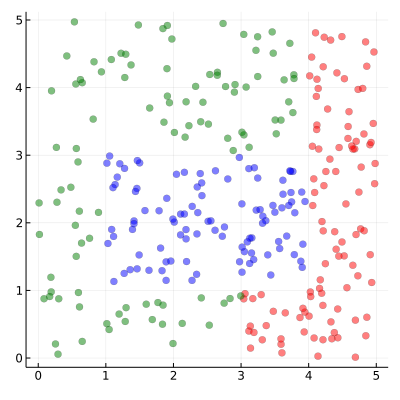

In [6]:
isred(x,y) = x > 4 || (x ≥ 3 && y < 1)
isgreen(x,y) = x < 1 || (x < 3 && y < 1 || x ≤ 4 && y > 3)
isblue(x,y) = !isred(x,y) && !isgreen(x,y)
function randpoint(iscolor)
    while true
        x,y = 5rand(2)
        if iscolor(x,y)
            return [x,y]
        end
    end
end

n = 100
function scatter_rgb()
    p = plot(size = (400,400), ratio = 1, legend = false)
    for (checker, color) in zip([isred, isgreen, isblue], [:red, :green, :blue])
        scatter!(p, [Tuple(randpoint(checker)) for _ in 1:n],
                 markersize = 4, markerstrokewidth = 0.3,
                 color = color, markeropacity = 0.5)
    end
    p
end
scatter_rgb()

In [7]:
features = vcat([vcat([randpoint(checker)' for _ in 1:n]...) for checker in [isred, isgreen, isblue]]...)
labels = repeat([1,2,3], inner = n); 

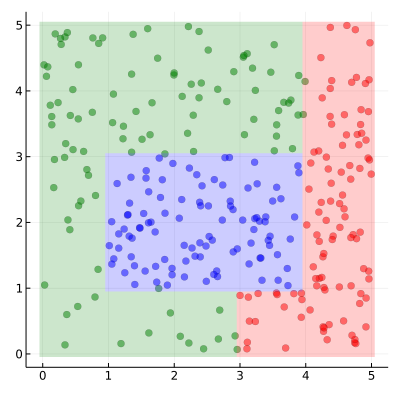

In [8]:
model = DecisionTree.DecisionTreeClassifier(max_depth=4)
DecisionTree.fit!(model, features, labels)
scatter_rgb()
heatmap!(0:0.1:5, 0:0.1:5, (x,y) -> DecisionTree.predict(model, [x,y]),
        colorbar = false, fillcolor = cgrad([:red, :green, :blue]),
        ratio = 1, size = (400,400), fillopacity = 0.2)

---

## Problem 4

Implement a recursive decision tree classifier from scratch. Your basic building blocks should be the *nodes* of the decision tree, including leaf nodes (the terminal nodes in decision tree paths), and decision nodes (the other ones). 

In [9]:
abstract type AbstractNode end

struct LeafNode <: AbstractNode
   prediction 
end
    
struct DecisionNode <: AbstractNode
    feature::Integer
    threshold::Real
    leftchild::AbstractNode
    rightchild::AbstractNode
end

In [10]:
X, y = DecisionTree.load_data("iris");

In [11]:
"""
Return a vector of class counts for the points 
whose feature value in the position `feature_index` 
is less than `threshold` if `op` is `<`, or greater 
if `op` is >
"""
function split_counts(X, y, feature_index, threshold, op)
    unique_labels = unique(y)
    counts = Dict(zip(unique_labels, zeros(Int64, length(unique_labels))))
    for (row, label) in zip(eachrow(X),y)
        if op(row[feature_index], threshold)
            counts[label] += 1
        end
    end
    collect(values(counts))
end

"""
Split data along feature `i`, by selecting the threshold
with the best split according to the weighted Gini impurity
loss. Return a pair (min_objective_value, threshold).
"""
function split_data(X, y, i)
    gini(p) = 1 - sum(p.^2)
    function loss(x)
        left_counts = split_counts(X, y, i, x, <) 
        left_total = sum(left_counts)
        right_counts = split_counts(X, y, i, x, ≥) 
        right_total = sum(right_counts)
        left_total * gini(left_counts / left_total) + 
            right_total * gini(right_counts / right_total)
    end
    function midpoints(v)
        s = sort(v)
        0.5(s[1:end-1] + s[2:end])
    end
    xs = midpoints(X[:,i])
    min_value, min_index = findmin([loss(x) for x in xs])
    threshold = xs[min_index]
    min_value, threshold
end

"""
Split data by choosing the best feature to split on. Return 
feature_index and threshold.
"""
function split_data(X, y)
    featuremins = [split_data(X, y, i) for i in 1:size(X,2)]
    minloss, feature_index = findmin([value for (value,threshold) in featuremins])
    threshold = featuremins[feature_index][2]
    feature_index, threshold
end

split_data

In [12]:
function decision_tree(X, y; depth=3)
    if depth == 0 || length(unique(y)) == 1
        LeafNode(StatsBase.mode(y))
    else
        feature_index, threshold = split_data(X, y)
        inds_left = X[:, feature_index] .< threshold
        inds_right = X[:, feature_index] .≥ threshold
        DecisionNode(feature_index, threshold, 
                     decision_tree(X[inds_left, :], y[inds_left], depth = depth - 1),
                     decision_tree(X[inds_right, :], y[inds_right], depth = depth - 1))
    end
end
    
function predict(node::DecisionNode, x)    
    if x[node.feature] < node.threshold
        predict(node.leftchild, x)
    else
        predict(node.rightchild, x)
    end
end

predict(node::LeafNode, x) = node.prediction

predict (generic function with 2 methods)

In [13]:
X = [randn(100, 2); [2 2] .+ randn(100, 2)]
y = repeat([1,2], inner = 100)
tree = decision_tree(X, y, depth = 4)

DecisionNode(2, 1.2538159790904873, DecisionNode(1, 2.3665780553047284, DecisionNode(1, 0.543985493575099, LeafNode(1), DecisionNode(2, 0.2794603417991135, LeafNode(1), LeafNode(1))), LeafNode(2)), DecisionNode(1, 0.5254966094333802, DecisionNode(2, 1.7574995041777344, DecisionNode(1, 0.1794240155676804, LeafNode(1), LeafNode(1)), DecisionNode(1, 0.39911616926660864, LeafNode(2), LeafNode(1))), DecisionNode(1, 1.3564621025042043, DecisionNode(1, 1.3324039330269466, LeafNode(2), LeafNode(1)), LeafNode(2))))

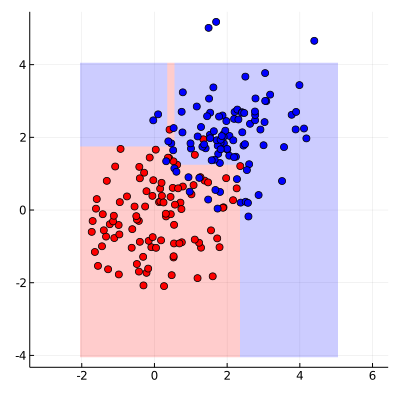

In [14]:
heatmap(-2:0.1:5, -4:0.1:4, (x,y) -> predict(tree, [x,y]), color = cgrad([:red, :blue]),
        ratio = 1, size = (400, 400), fillopacity = 0.2, legend = false)
scatter!(X[y .== 1, 1], X[y .== 1, 2], color = :red)
scatter!(X[y .== 2, 1], X[y .== 2, 2], color = :blue)

---

## Problem 5 (Challenge)

Besides Gini impurity, other measures can also be used to decide which feature to split upon at each node in the decision tree. One popular measure is information gain, defined below.

Consider training data set $D = \{\mathbf{x}_i, y_i\}_{i=1}^N$ consisting of $N$ observations. Let $x_i^a$ denote the $a^\text{th}$ feature of $i^\text{th}$ observation. Define the set:
$$ S_a(v) = \{ \mathbf{x}_i \in D | x_i^a = v \} $$
of training features whose $a^\text{th}$ components are the same.

Then, we define conditional entropy as:
$$ H(D|a) = \sum_v \frac{|S_a(v)|}{|D|} H(S_a(v)) $$

where: $H(X) = - \sum_{x_k \in X} \mathbb{P}(x_k) \log(\mathbb{P}(x_k))$ is the Shannon entropy. Finally, we can measure information gained from the $a^\text{th}$ component as:

$$ IG(D,a) = H(D) - H(D|a) $$

What are some of the advantages/disadvantages of using information gain instead of Gini impurity to construct our decision tree?